#　Python  決定木 vs LightGBM     精度差を徹底比較してみた

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import lightgbm as lgb
import shap

In [2]:
#=============================================
# 1. データ読み込む
#=============================================
df = pd.read_csv("L用_sample_car_data_数値.csv", encoding='shift-JIS')
#df_moto = pd.DataFrame(df_moto)
df.head(3)

,customer_id,family,age,gender,income,marital_status,children,region,employment_type,hobby,car_preference,previous_car_owner,previous_manufacturer,manufacturer
0,1,3,31,0,828,1,0,0,2,1,2,1,6.0,5
1,2,3,46,0,482,1,0,1,0,3,1,1,6.0,6
2,3,1,51,0,718,0,0,2,0,4,2,0,NaN,6


In [3]:
# 数値で残す列
numeric_cols = ["family", "age","children", "income"]

# ID・目的変数
exclude_cols = ["customer_id", "manufacturer"]

# カテゴリ変換対象
categorical_cols = [
    col for col in df.columns
    if col not in exclude_cols + numeric_cols
]

# カテゴリ型にする
df[categorical_cols] = df[categorical_cols].astype("category")

In [4]:

#=============================================
# 2. 説明変数
#=============================================
X_df = df.drop(['customer_id', 'manufacturer'], axis=1)

#=============================================
# 3. 目的変数
#=============================================
y_df = df['manufacturer']


# クラス数を確認
classes = np.unique(y_df)
print("クラス:", classes)


クラス: [0 1 2 3 4 5 6]


In [5]:

#=============================================
# 2. 説明変数
#=============================================
X_df = df.drop(['customer_id', 'manufacturer'], axis=1)

#=============================================
# 3. 目的変数
#=============================================
y_df = df['manufacturer']


# クラス数を確認
classes = np.unique(y_df)
print("クラス:", classes)

#=============================================
# 4. データ分割
#=============================================
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, random_state=0)

print("訓練データ数:", len(X_train))
print("テストデータ数:", len(X_test))



# ------------------------
# 2b. LightGBM
# ------------------------
# import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_test = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'verbose': -1,
}
lgb_model = lgb.train(params, lgb_train, num_boost_round=50)

y_pred_lgb = (lgb_model.predict(X_test) > 0.5).astype(int)

クラス: [0 1 2 3 4 5 6]
訓練データ数: 300
テストデータ数: 100


In [6]:
#=============================================
# 6. LightGBM
#=============================================
if len(classes) == 2:
    objective = 'binary'
    metric = 'binary_error'
else:
    objective = 'multiclass'
    metric = 'multi_error'

params = {
    'objective': objective,
    'metric': metric,
    'verbose': -1,
}
if objective == 'multiclass':
    params['num_class'] = len(classes)

#=============================================
# LightGBM用データセットを作成（特徴量名を指定）
#=============================================
lgb_train = lgb.Dataset(
    X_train.values,
    label=y_train.values,
    feature_name=X_df.columns.tolist()
)

lgb_model = lgb.train(params, lgb_train, num_boost_round=50)
#num_boost_round=50は完全にデフォルトで、小規模なデータでは早すぎて学習が終わってることがあります。
#lgb_model = lgb.train(params, lgb_train, num_boost_round=200)
#=============================================
# テストデータで予測
#============================================
y_pred_lgb_prob = lgb_model.predict(X_test.values)

if objective == 'binary':
    y_pred_lgb = (y_pred_lgb_prob > 0.5).astype(int)
else:
    y_pred_lgb = np.argmax(y_pred_lgb_prob, axis=1)

# ==============================
# SHAP値計算
# ==============================
explainer = shap.Explainer(lgb_model, X_df)
shap_values = explainer(X_df)
print("SHAP values shape:", shap_values.values.shape)


SHAP values shape: (400, 12)


【LightGBM】     Accuracy: 0.7
【LightGBM】     F1 Score: 0.6967375886524824


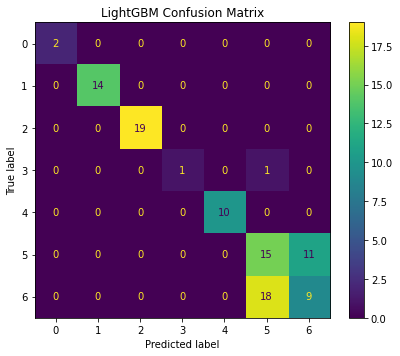

In [7]:
#=============================================
# 精度評価
#=============================================
print("【LightGBM】     Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("【LightGBM】     F1 Score:", f1_score(y_test, y_pred_lgb, average='weighted'))

#=============================================
# 混同行列の表示
#=============================================
fig, ax = plt.subplots(figsize=(6, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lgb, ax=ax)
ax.set_title("LightGBM Confusion Matrix")

plt.tight_layout()
plt.show()


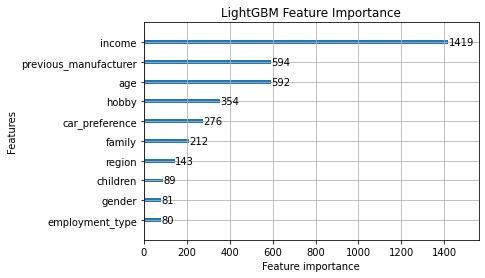

In [8]:
#=============================================
# 10. LightGBMの特徴量重要度 (特徴量名表示)
#=============================================
ax = lgb.plot_importance(
    lgb_model,
    max_num_features=10
)
plt.title("LightGBM Feature Importance")

plt.savefig("比較用_LightGBM_Feature.png", dpi=300)

df = df_moto

In [9]:


# ==============================
# LightGBMパラメータ設定
# ==============================
params = {
    'objective': 'multiclass',
    'metric': 'multi_error',
    'num_class': len(classes),
    'verbose': -1
}

# ==============================
# 7. 学習（100回で学習）
# ==============================
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)

# ==============================
# 8. 全データに対する予測
# ==============================
y_all_pred_prob = lgb_model.predict(X_df.values)  # 予測確率
y_all_pred = np.argmax(y_all_pred_prob, axis=1)  # 予測クラスラベル

# ==============================
# 9. 上位3候補の抽出
# ==============================
top3_classes = np.argsort(y_all_pred_prob, axis=1)[:, ::-1][:, :3]
top3_probs = np.sort(y_all_pred_prob, axis=1)[:, ::-1][:, :3]


# ==============================
# 10. 元データに結果を追加
# ==============================
df["predicted_manufacturer"] = y_all_pred

for i in range(y_all_pred_prob.shape[1]):
    df[f"prob_class_{i}"] = y_all_pred_prob[:, i]

#df["top1_class"] = top3_classes[:, 0]
#df["top1_prob"] = top3_probs[:, 0]
#df["top2_class"] = top3_classes[:, 1]
#df["top2_prob"] = top3_probs[:, 1]
#df["top3_class"] = top3_classes[:, 2]
#df["top3_prob"] = top3_probs[:, 2]

for i in range(3):
    df[f"top{i+1}_class"] = top3_classes[:, i]
    df[f"top{i+1}_prob"] = top3_probs[:, i]
df.head(3)




print(df[[
    "manufacturer",
    "predicted_manufacturer",
    "top1_class", "top1_prob",
    "top2_class", "top2_prob",
    "top3_class", "top3_prob"
]].head())


# =======================================
# 正解が top3 に含まれている割合（Top-3 Accuracy）
# =======================================

top3_accuracy = np.mean([
    y_true in top3 for y_true, top3 in zip(df["manufacturer"], top3_classes)
])
print(f"Top-3 Accuracy: {top3_accuracy:.3f}")

   manufacturer  predicted_manufacturer  top1_class  top1_prob  top2_class  \
0             5                       5           5   0.964862           6   
1             6                       5           5   0.991957           6   
2             6                       6           6   0.990222           5   
3             2                       2           2   0.999936           5   
4             6                       5           5   0.973125           6   

   top2_prob  top3_class  top3_prob  
0   0.034541           4   0.000267  
1   0.007901           4   0.000103  
2   0.008979           3   0.000670  
3   0.000039           6   0.000019  
4   0.025558           3   0.001231  
Top-3 Accuracy: 1.000


In [10]:
# =======================================
# 正解が topN の何番目だったかを記録
# =======================================
def top_rank(row):
    true_class = row["manufacturer"]
    top_classes = [row["top1_class"], row["top2_class"], row["top3_class"]]
    return top_classes.index(true_class) + 1 if true_class in top_classes else None

df["correct_rank"] = df.apply(top_rank, axis=1)
print(df["correct_rank"].value_counts())

1    370
2     30
Name: correct_rank, dtype: int64


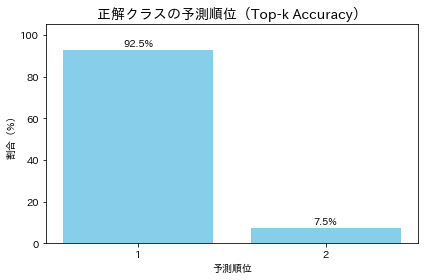

In [11]:
# =======================================
#正解の順位別の件数・割合を可視化するコード（matplotlib）
# =======================================
import matplotlib.pyplot as plt
import japanize_matplotlib  # 日本語対応

rank_counts = df["correct_rank"].value_counts().sort_index()
rank_percent = (rank_counts / rank_counts.sum()) * 100

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(rank_percent.index.astype(str), rank_percent.values, color='skyblue')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1,
            f"{height:.1f}%", ha='center', va='bottom')

ax.set_title("正解クラスの予測順位（Top-k Accuracy）", fontsize=14)
ax.set_xlabel("予測順位")
ax.set_ylabel("割合（%）")
plt.ylim(0, 105)
plt.tight_layout()
plt.show()


# ==============================
# 上位3クラスの抽出
# ==============================
top3_classes = np.argsort(y_all_pred_prob, axis=1)[:, ::-1][:, :3]
top3_probs = np.sort(y_all_pred_prob, axis=1)[:, ::-1][:, :3]

for i in range(3):
    df[f"top{i+1}_class"] = top3_classes[:, i]
    df[f"top{i+1}_prob"] = top3_probs[:, i]
df.head(3)


# ==============================
# 11. SHAP値計算
# ==============================
explainer = shap.Explainer(lgb_model, X_df)
shap_values = explainer(X_df)
print("SHAP values shape:", shap_values.values.shape)


# ==============================
# 上位6クラスの抽出
# ==============================
top6_classes = np.argsort(y_all_pred_prob, axis=1)[:, ::-1][:, :6]
top6_probs = np.sort(y_all_pred_prob, axis=1)[:, ::-1][:, :6]

for i in range(6):
    df[f"top{i+1}_class"] = top6_classes[:, i]
    df[f"top{i+1}_prob"] = top6_probs[:, i]

# ==============================
# 11. SHAP値計算
# ==============================
explainer = shap.Explainer(lgb_model, X_df)
shap_values = explainer(X_df)
print("SHAP values shape:", shap_values.values.shape)



# ==============================
# 12. 全特徴量のSHAP値データフレーム作成
# ==============================
results_top3 = []
top3_df = pd.DataFrame(results_top3)

In [12]:


# ==============================
# 13. 上位3寄与特徴量抽出
# ==============================
results_top3 = []

for i in range(len(df)):
    pred_class = df.loc[i, "predicted_manufacturer"]
    shap_vals = shap_values.values[i, :].flatten()
    features = list(shap_values.feature_names)

    # 絶対値で上位3特徴量を選ぶ
    top_idx = np.argsort(np.abs(shap_vals))[::-1][:3]
    top_features = [features[j] for j in top_idx]
    top_values = [shap_vals[j] for j in top_idx]

    tmp = {
        "customer_id": df.loc[i, "customer_id"],
        "predicted_class": pred_class,
        "top1_feature": top_features[0],
        "top1_value": top_values[0],
        "top2_feature": top_features[1],
        "top2_value": top_values[1],
        "top3_feature": top_features[2],
        "top3_value": top_values[2]
    }
    results_top3.append(tmp)

top3_df = pd.DataFrame(results_top3)


In [13]:
top3_df.head(3)

,customer_id,predicted_class,top1_feature,top1_value,top2_feature,top2_value,top3_feature,top3_value
0,1,5,car_preference,-1.397232,age,-0.865379,income,0.808980
1,2,5,income,-1.224238,car_preference,-1.019621,hobby,-0.660659
2,3,6,hobby,2.539131,car_preference,-1.911194,income,-1.909915


In [14]:

# ==============================
# 14. predicted_class列に名前統一
# ==============================
df = df.rename(columns={"predicted_manufacturer": "predicted_class"})
df.to_csv("1.csv", index=False, encoding="utf-8-sig")
df.head(3)

,customer_id,family,age,gender,income,marital_status,children,region,employment_type,hobby,...,prob_class_4,prob_class_5,prob_class_6,top1_class,top1_prob,top2_class,top2_prob,top3_class,top3_prob,correct_rank
0,1,3,31,0,828,1,0,0,2,1,...,0.000267,0.964862,0.034541,5,0.964862,6,0.034541,4,0.000267,1
1,2,3,46,0,482,1,0,1,0,3,...,0.000103,0.991957,0.007901,5,0.991957,6,0.007901,4,0.000103,2
2,3,1,51,0,718,0,0,2,0,4,...,0.000005,0.008979,0.990222,6,0.990222,5,0.008979,3,0.000670,1


In [15]:

# ==============================
# 15. マージ
# ==============================
df_merged = pd.merge(df, top3_df, on=["customer_id", "predicted_class"], how="left")

# ==============================
# 16. 列名リネーム（必要に応じて追加してください）　		
# ==============================
rename_dict = {
    "customer_id": "顧客ID",
    "family": "同居家族",
    "age": "年齢",
    "gender": "性別",
    "income": "世帯収入",
    "marital_status": "婚姻状況",
    "region": "居住地",
    "employment_type": "雇用形態",
    "hobby": "趣味",
    "car_preference": "好みのボディタイプ",
    "previous_car_owner": "保有歴",
    "top1_feature": "上位1特徴量",
    "top1_value": "上位1寄与度",
    "top2_feature": "上位2特徴量",
    "top2_value": "上位2寄与度",
    "top3_feature": "上位3特徴量",
    "top3_value": "上位3寄与度",
    "prob_class_0": "メーカー0の確率",
    "prob_class_1": "メーカー1の確率",
    "prob_class_2": "メーカー2の確率",
    "prob_class_3": "メーカー3の確率",
    "prob_class_4": "メーカー4の確率",
    "prob_class_5": "メーカー5の確率",
    "prob_class_6": "メーカー6の確率",
    "top1_class": "トップ1候補メーカー",
    "top1_prob": "トップ1確率",
    "top2_class": "トップ2候補メーカー",
    "top2_prob": "トップ2確率",
    "top3_class": "トップ3候補メーカー",
    "top3_prob": "トップ3確率",
#    "top4_class": "トップ4候補メーカー",
#    "top4_prob": "トップ4確率",
#    "top5_class": "トップ5候補メーカー",
#    "top5_prob": "トップ5確率",
#    "top6_class": "トップ6候補メーカー",
#    "top6_prob": "トップ6確率",
}
df_merged = df_merged.rename(columns=rename_dict)

# ==============================
# 17. CSV出力
# ==============================
df_merged.to_csv("predictions_with_top3", index=False, encoding="utf-8-sig")
print("✅ 完了：最終形態predictions_with_top6.csv に SHAP上位特徴量も含めて保存しました！")

✅ 完了：最終形態predictions_with_top6.csv に SHAP上位特徴量も含めて保存しました！


# 確率のカラム名に「確率」が含まれている列を抽出
prob_cols = [col for col in df_merged.columns if "確率" in col]

# それらの列をパーセントに変換（100倍）
df_merged[prob_cols] = df_merged[prob_cols] * 100

# カラム名を「元名(%)」に変更
rename_dict = {col: f"{col}(%)" for col in prob_cols}
df_merged = df_merged.rename(columns=rename_dict)

In [16]:
#=============================================
#　Topデレクトリとリストファイルを開く
#=============================================
import os
import os.path as osp
current_dpath = os.getcwd()

os.startfile(current_dpath)
os.startfile(current_dpath + "\\predictions_with_top3.csv")

✅ 完了：最終形態predictions_with_top6.csv に SHAP上位特徴量も含めて保存しました！


✅ コード：メーカーごとの特徴量重要度ランキング

In [ ]:
ありがとうございます、以下のような形式ですね：

📊 入力データ（例）
メーカー	特徴量	平均SHAP値
0	region	5.35174
0	income	4.59892
0	age	0.26617
0	hobby	0.15247
0	car_preference	0.12971
1	income	4.48807

🔍 読み取り方（解説）
✅ 「メーカーごとの重要な特徴量」がわかる表
メーカー列（0, 1, ...） は予測対象のクラス（たとえば車メーカーの種類）。

特徴量列 は、予測に使われた説明変数（age, incomeなど）。

平均SHAP値 は、その特徴量が「どの程度そのクラスの予測に貢献したか」の平均的な大きさ（絶対値）。

値が大きいほど、「そのクラスの予測に強く関与した特徴量」と言える。

🧠 具体的な読み方
例：メーカー 0 に対して
特徴量	平均SHAP値	解釈
region	5.35	地域が最も予測に強く関与（エリアで好まれやすい傾向）
income	4.60	世帯収入も非常に重要な判断材料
age	0.27	年齢は補助的な要素
hobby	0.15	趣味も多少は影響あり
car_preference	0.13	好みのボディタイプは比較的影響小さい

→ このように「メーカーごとに、何が購買に影響しているのか？」が見える。

🏢 ビジネス応用例
1. パーソナライズ施策に活用
たとえば、region（地域）が影響力大きいなら、

地域別に販売戦略を変える

地域特化の広告（例：「〇〇地方で人気！」）

2. モデル説明の資料に
モデルの透明性を担保する説明資料として

「なぜこのメーカーと予測されたか」の根拠を示す際に有用

3. 特徴量選定や改善のヒントに
不要な特徴量や、もっと影響の大きい新しい特徴量の候補を検討できる。



In [17]:
import pandas as pd
import numpy as np

# SHAP値と特徴量名をDataFrameに変換
shap_df = pd.DataFrame(shap_values.values, columns=X_df.columns)
shap_df["predicted_class"] = df["predicted_class"].values  # 予測されたクラスを結合

# クラスごとの SHAP値の平均（特徴量別）を求める
summary_list = []

for cls in sorted(df["predicted_class"].unique()):
    shap_mean = shap_df[shap_df["predicted_class"] == cls].drop(columns="predicted_class").mean().abs()
    shap_mean_sorted = shap_mean.sort_values(ascending=False)

    for feature, value in shap_mean_sorted.items():
        summary_list.append({
            "メーカー": cls,
            "特徴量": feature,
            "平均SHAP値": round(value, 5)
        })

# DataFrameとしてまとめる
shap_summary_df = pd.DataFrame(summary_list)

# メーカーごとに上位5個を表示（必要なら変更可能）
topN = 5
display_df = shap_summary_df.groupby("メーカー").head(topN)

# 表示（またはCSV出力も可能）
#print(display_df)

# CSV保存（必要であれば）
display_df.to_csv("メーカー別_SHAP_特徴ランキング.csv", index=False, encoding="utf-8-sig")


✅ 可視化コード（メーカーごとの特徴量重要度）
python
コピーする
編集する


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 例のデータフレームを仮に shap_summary とする
# （列名：['メーカー', '特徴量', '平均SHAP値']）
# データがなければこのように作成してください
# shap_summary = pd.DataFrame({
#     "メーカー": [0, 0, 0, 1, 1],
#     "特徴量": ["region", "income", "age", "income", "hobby"],
#     "平均SHAP値": [5.35, 4.6, 0.27, 4.4, 1.2]
# })

# 可視化設定
sns.set(style="whitegrid")
メーカー一覧 = shap_summary["メーカー"].unique()

for maker in メーカー一覧:
    df_m = shap_summary[shap_summary["メーカー"] == maker]
    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=df_m,
        x="平均SHAP値",
        y="特徴量",
        palette="viridis"
    )
    plt.title(f"メーカー {maker} の特徴量重要度", fontsize=14)
    plt.xlabel("平均SHAP値（重要度）")
    plt.ylabel("特徴量")
    plt.tight_layout()
    plt.show()

正解のメーカー（＝正解ラベル）に対して SHAP ランキングを出す方法を以下に整理してご説明＆コード提供します
✅ 目的
「実際に購入したメーカー（＝正解ラベル）」にとって、どの特徴量がどのくらい予測に影響していたか？を SHAP 値で確認したい。

🛠️ 手順（正解ラベルの SHAP ランキングを取る）

import numpy as np
import pandas as pd

# SHAP値を持つオブジェクト（shape: [n_samples, n_features]）
# shap_values.values.shape == (400, 12)

top_feats = []

for i in range(shap_values.values.shape[0]):
    shap_row = shap_values.values[i]  # 各サンプルのSHAP値（12次元）
    
    # 影響の大きい順（絶対値が大きい順）にインデックス取得
    top_idx = np.argsort(np.abs(shap_row))[::-1][:3]

    # 上位3つの特徴量とそのSHAP値を記録
    top_feats.append({
        "top1_feature": X_df.columns[top_idx[0]],
        "top1_value": shap_row[top_idx[0]],
        "top2_feature": X_df.columns[top_idx[1]],
        "top2_value": shap_row[top_idx[1]],
        "top3_feature": X_df.columns[top_idx[2]],
        "top3_value": shap_row[top_idx[2]],
    })

# DataFrameに変換
shap_top_df = pd.DataFrame(top_feats)

# 元データに結合（インデックスずれに注意）
df = pd.concat([df.reset_index(drop=True), shap_top_df], axis=1)

# 必要に応じて表示
print(df[[
    "top1_feature", "top1_value",
    "top2_feature", "top2_value",
    "top3_feature", "top3_value"
]].head())

df.to_csv("正解のメーカ_SHAP_ランキング", index=False, encoding="utf-8-sig")

In [26]:
df.to_csv("正解のメーカ_SHAP_ランキング", index=False, encoding="utf-8-sig")

In [ ]:
LightGBMの予測を正しく理解する方法
1. 特徴量重要度（Feature Importance）の確認
どの説明変数がモデルにどれだけ影響を与えたかを把握する。

plot_importance()やfeature_importances_で全体的な影響度を見る。

2. SHAP値（SHapley Additive exPlanations）を使う
各特徴量が各予測にどれだけ寄与しているかを詳細に可視化できる。

グローバル（全体傾向）だけでなく、個別予測ごとの寄与も分かるので理解が深まる。

PythonのshapライブラリとLightGBMは相性抜群。

python
コピーする
編集する
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# 全体の特徴量の影響を見る
shap.summary_plot(shap_values, X)

# 個別サンプルの特徴量の影響を見る
shap.force_plot(explainer.expected_value, shap_values[0], X.iloc[0])
3. 部分依存プロット（Partial Dependence Plot）
特定の特徴量が予測に与える影響を平均的に見るグラフ。

変数の増減に対して予測値がどう変わるかがわかる。

